# Lab ML for DS SS23
## Project 2
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [46]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import pdist
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from itertools import combinations_with_replacement, combinations


# 1. Importing the QM7 Dataset

In [47]:
# The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.
qm7 = loadmat("./qm7.mat")
print(qm7.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])


In [48]:
# R (7165×23×3) contains for each molecule and atom a triplet representing the 3d coordinates
display(qm7['R'].shape)
display(qm7['R'][0])

(7165, 23, 3)

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [49]:
# Z (7165×23) contains for each molecule and atom of the molecule the corresponding atomic number

# 0 == no atom at this index
# 1 == hydrogen (H) 1
# 6 == carbon (C) 4
# 7 == nitrogen (N) 3
# 8 == oxygen (O) 2
# 16 == sulfur (S) 6
display(qm7['Z'].shape)
display(qm7['Z'][0])
atoms = ["H", "C", "N", "O", "S"]

(7165, 23)

array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

(1, 7165)

-417.96

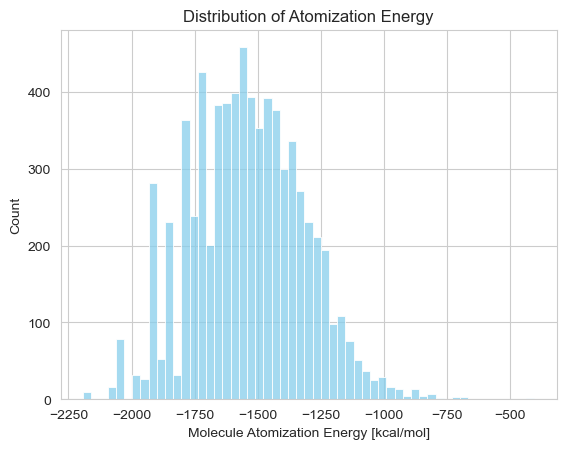

In [50]:
# T (1 x 7165) contains for each molecule the atomization energy (computed via quantum-chemical simulation)
display(qm7['T'].shape)
display(qm7['T'][0, 0])

g = sns.histplot(qm7['T'][0], color="skyblue")
g.set_xlabel('Molecule Atomization Energy [kcal/mol]')
plt.title("Distribution of Atomization Energy")
plt.show()

# 1.1 Visualizing Molecules

### "Quick and dirty approach"

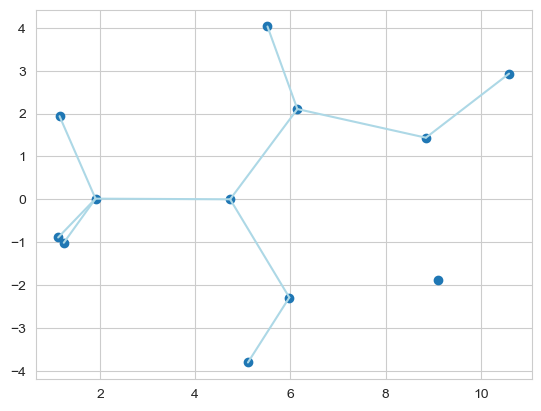

In [51]:
nr = 6432

mol = qm7["R"][nr]
sym = qm7["Z"][nr]

sym = sym[sym > 0]
mol = mol[: len(sym)]

plt.scatter(x=mol[:, 0], y=mol[:, 1])


# generate bonds
thresh = 3

mask = np.argwhere(pdist(mol, metric="euclidean") < thresh)[:, 0]
bonds = np.vstack(np.triu_indices(len(mol), 1)).T[mask]

for i in range(len(bonds)):
    plt.plot(mol[bonds[i]][:, 0], mol[bonds[i]][:, 1], color="lightblue")


Observation: In this 2-D visualisation we chose a fixed threshold of three. This works well enough for many bonds, but not for all of them. Different atoms have different bond lengths: as can be seen in this particular example, one atom is further away from the others. In addition to that, some atoms have multiple bonds between the same atoms (e.g. double, tripple, etc.) which is not expressed in the visualisation.



### Atomic Simulation Environment
To get a more sophisticated 3D-visualization we make use of some other libraries.

In [52]:
#from ase import Atoms
#import nglview
#import ase.visualize

#system = Atoms(positions=mol, symbols=sym)
# ase.visualize.view(system, viewer="x3d")

#view = nglview.show_ase(system)
#view.add_ball_and_stick() # HOW TO SPECIFY BONDS?????
#view

# Other viz approaches
# https://www.kaggle.com/code/mykolazotko/3d-visualization-of-molecules-with-plotly
# nglview

# 2. Data Representation, ML Model and Explanations

# 2.1 Data Representation: Atoms

We first decomposed the molecules into individual elements - atoms - and saved a representation of each molecule as an array with the counts of each atom type.

In [53]:
# one hot encoding of [HCNOS]

# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N)
# 8 == oxygen (O)
# 16 == sulfur (S)

z = qm7["Z"].astype(np.int8)

z[z == 1] = 1
z[z == 6] = 2
z[z == 7] = 3
z[z == 8] = 4
z[z == 16] = 5

Z_hot = np.eye(6)[z]
Z_hot = Z_hot[:, :, 1:]  # drop 0 dimension

# sum of to create the representation
x = np.sum(Z_hot, axis=1).astype(int)

print("Shape:", x.shape)
print("Resulting representations:")
print(x)


Shape: (7165, 5)
Resulting representations:
[[ 4  1  0  0  0]
 [ 6  2  0  0  0]
 [ 4  2  0  0  0]
 ...
 [ 9  6  1  0  0]
 [10  7  0  0  0]
 [12  7  0  0  0]]


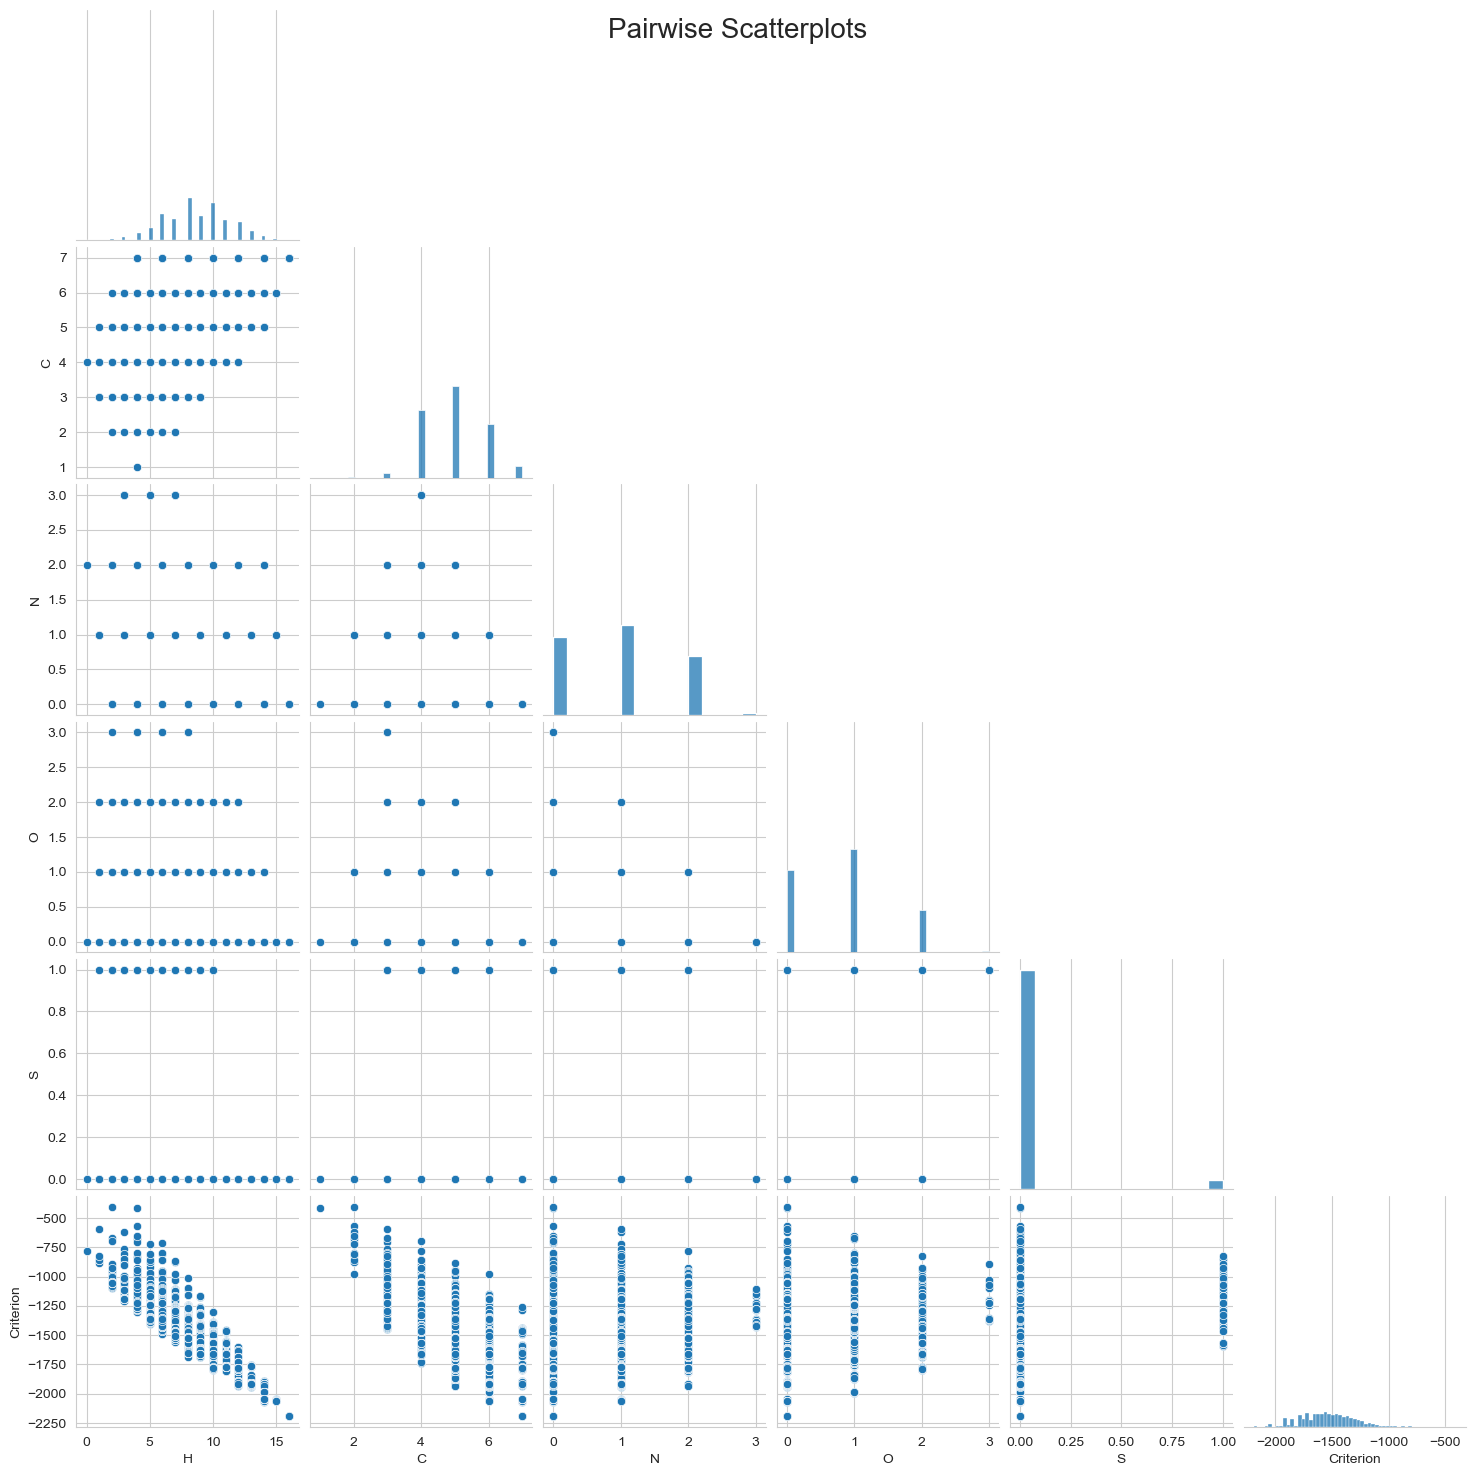

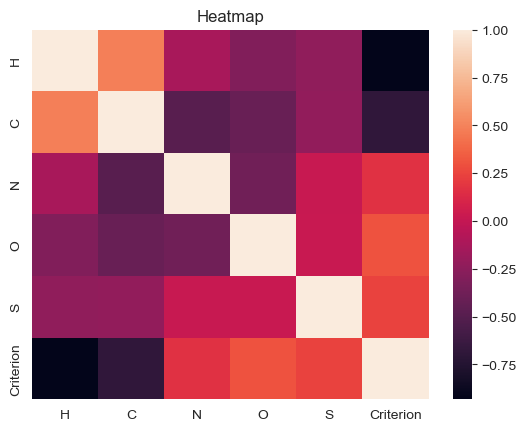

In [54]:
import pandas as pd

y = np.reshape(qm7["T"][0], (-1, 1))
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns = ["H", "C", "N", "O", "S", "Criterion"])

sns.pairplot(df, corner=True)
plt.suptitle("Pairwise Scatterplots", fontsize=20)
plt.show()

sns.heatmap(df.corr())
plt.title("Heatmap")
plt.show()

In [55]:
print(df.corr())

                  H         C         N         O         S  Criterion
H          1.000000  0.483864 -0.125100 -0.298140 -0.236983  -0.931799
C          0.483864  1.000000 -0.486695 -0.413210 -0.225661  -0.688390
N         -0.125100 -0.486695  1.000000 -0.373496  0.017874   0.169763
O         -0.298140 -0.413210 -0.373496  1.000000  0.025079   0.299107
S         -0.236983 -0.225661  0.017874  0.025079  1.000000   0.243362
Criterion -0.931799 -0.688390  0.169763  0.299107  0.243362   1.000000


Observation: The pairwise scatterplots and correlation matrix reveal a lack of multicollinearity in the data - the predictor variables are not highly correlated with one another, except for hydrogen and carbon (corr = 0.48).
We can also see a strong linear relationship between the atomisation energy and hydrogen (corr = -0.93) as well as carbon (corr = -0.69).


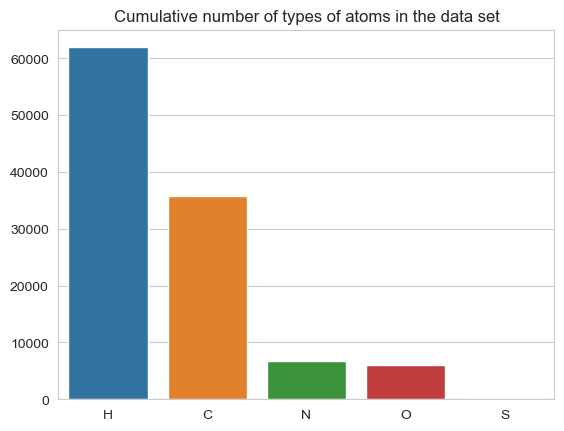

In [56]:
g = sns.barplot(x=atoms, y=np.sum(x, axis=0))
g.set_title('Cumulative number of types of atoms in the data set')
plt.show()

Observation: It is worth noting that hydrogen and carbon are the most common atoms in the data set.

# 2.2 Ridge Regression Model

We then split the data into train and test subsets and centered numbers of the atoms in the molecules.

In [57]:
def split_and_center(X, y, test_size, shuffle=True):
    # split train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=shuffle)

    # center data and target
    X_train_mean = np.mean(X_train, axis=0)
    y_train_mean = np.mean(y_train)
    print(X_train_mean)

    X_train = X_train - X_train_mean
    X_test = X_test - X_train_mean

    y_train = y_train - y_train_mean
    y_test = y_test - y_train_mean

    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test = split_and_center(x, qm7["T"][0], test_size=0.3)

[8.61894317 4.98703888 0.92961117 0.83808574 0.04287139]


In order to tune the regularisation parameter alpha for the Ridge regression model, we performed a grid search on the training data.

In [58]:
# Grid search to tune alpha using 10-fold cross validation

ridge = Ridge()
alpha_values = np.logspace(np.log10(1e-4), np.log10(100), num=100)
grid = dict(alpha=alpha_values)
search = GridSearchCV(
    ridge,
    grid,
    scoring=("neg_mean_absolute_error"), # 'r2', 'neg_mean_squared_error'
    cv=10,
    n_jobs=-1,
    refit="neg_mean_absolute_error",
    return_train_score=True,
)  

results = search.fit(X_train, y_train)


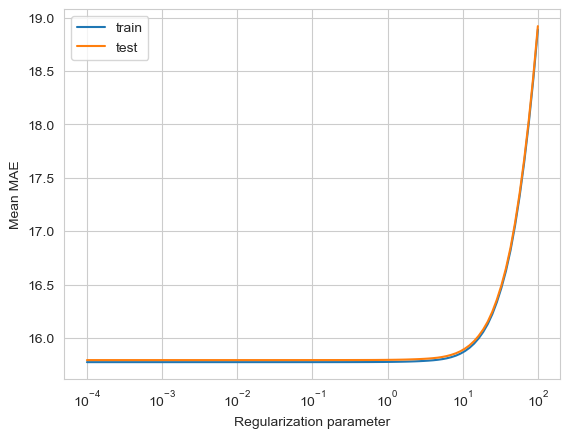

In [59]:
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

Observation: Low regualarisation parameter achieves the lowest MAE.

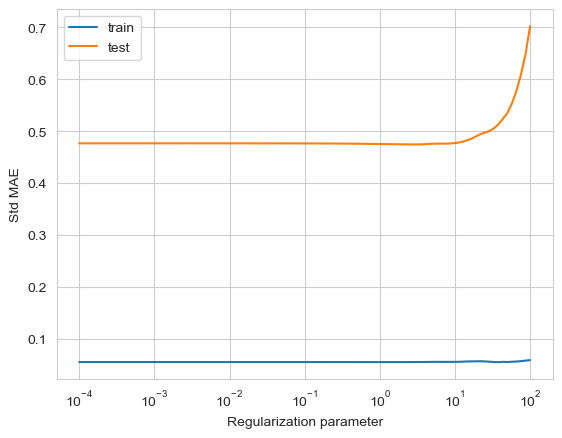

In [60]:
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Std MAE')
plt.legend(loc='upper left')
plt.show()

Observation: The standard deviation of the absolute error is very low and stable for low regualarisation parameter.

We plotted the regression model using the very low regularisation parameter (alpha= 0.0001) which resulted in our parameter tuning.

Best parameter: {'alpha': 0.0001}
R2: 0.992
MAE: 15.461
MSE: 403.582


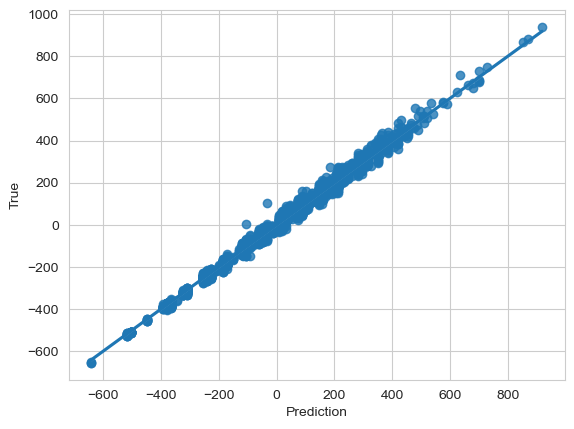

In [61]:
y_pred = search.best_estimator_.predict(X_test)
print("Best parameter:", results.best_params_)
print(f"R2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
g = sns.regplot(x=y_pred, y=y_test)
g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()

Since the regularisation parameter is so small we compared the results with performing a multiple linear regression without regularisation.

R2: 0.992
MAE: 15.461
MSE: 403.582


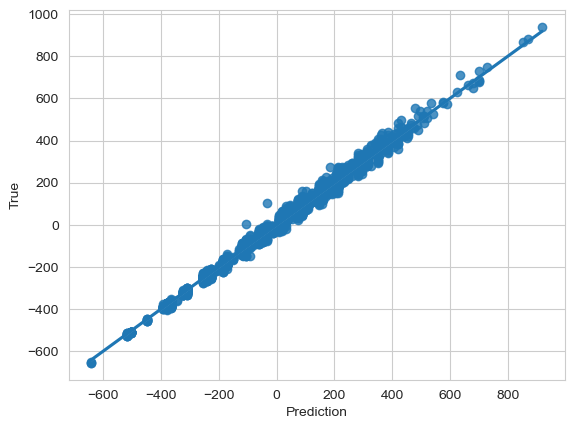

In [62]:
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"R2: {r2_score(y_test, y_pred_lr):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr):.3f}")

g = sns.regplot(x=y_pred_lr, y=y_test)
g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()

Observations:
The explained variance and error scores for these two regression models are identical. This is due to the fact that in the Ridge regression the penalty parameter is effectively 0, basically resulting in unpenalised linear regression model. Taken together with the tendency for the Ridge model to perform increasingly worse with higher regularisation term, we conclude that the Ridge regression introduces a non-beneficial bias. The possible reduction of the variance of the estimator does not seem to recuperate/improve the overall performance.
We can attribute this to fackt that we did not observe high multicolinearity in the data. In the absence of multicolinearity, linear regression tends to perform equally well or even better than Ridge regression. Ridge Regression, on the other hand, can come in hand in the case of a high number of included covariates.

We also observed that the explained variance is very high, even when fitting the regression to a low number of data points. This, too, points to a strong linear relationship between the independent and dependent variables. We observed that the most common atoms in the data, hydrogen and carbon, had a high linear relationship with the criterion. We therefore conclude that the underlying relationship in the data is highly linear.

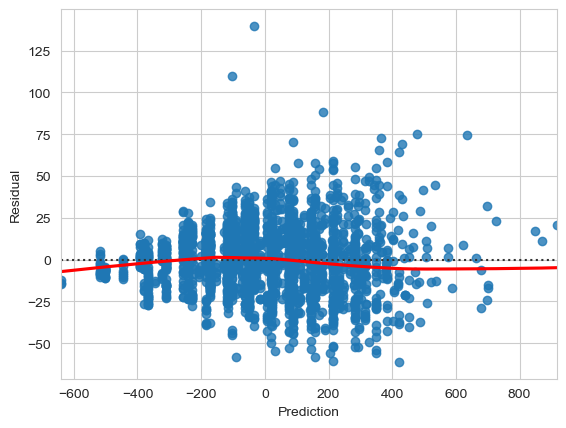

In [63]:
g = sns.residplot(x=y_pred, y=y_test, lowess=True, line_kws=dict(color="r"))
g.set_xlabel("Prediction")
g.set_ylabel("Residual")
plt.show()

Observation: There is no clear structure in the residual plot. The LOWESS curve, even if not completely straight, so not showing a strong trend. However, there is mode variance in the residuals on the right side of the graph. This might indicate that the specification of the model was not completely correct specification of the model and the regression coefficients might be somewhat skewed.


### Visualization for intuition: Impact of penalization on weights

In [64]:
ridge_ = Ridge()

weights_ = []
scores_ = []
for alpha in alpha_values:
    grid_ = dict(alpha = [alpha])
    search_ = GridSearchCV(ridge_, grid_, scoring=('neg_mean_squared_error'), cv=10, n_jobs=-1, refit = 'neg_mean_squared_error')
    results_ = search_.fit(X_train, y_train)
    weights_ += [results_.best_estimator_.coef_]
    scores_ += [results_.best_score_]

weights_ = np.array(weights_)

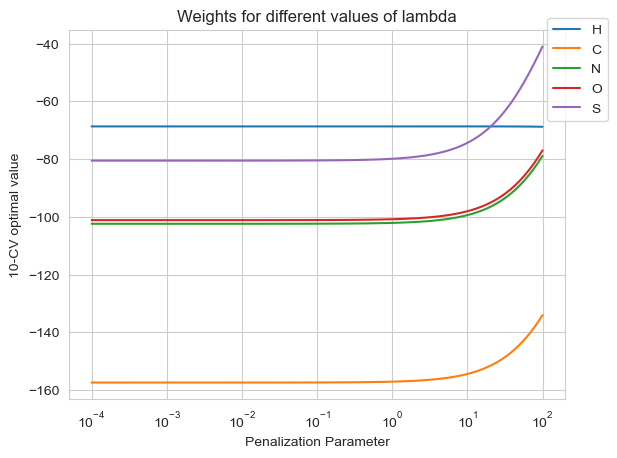

In [65]:
plt.plot(alpha_values, weights_)
plt.legend(atoms, bbox_to_anchor=(1.1, 1.05))
plt.xscale("log")
plt.title("Weights for different values of lambda")
plt.ylabel("10-CV optimal value")
plt.xlabel("Penalization Parameter")
plt.show()

Intuitively, we can see how the penalization works. Ridge introduces a shrinkage towards 0 with an increasing value of the penalization paramter. This leads to an introduced bias which possibely can reduce the estimators performance (i.e. MSE) by reducing the variance of the estimator.

# 2.3 Deeper Insights with Explanations 
# 3. Experiments 
# 3.1 Simple atom-based Representation

Fitting our best found model, we get the following MAE and weights for the different atom Types:

In [66]:
print(f"Best performing regularization parameter: {results.best_params_}")
print(f"MAE on validation set: {mean_absolute_error(y_test, search.best_estimator_.predict(X_test)):.3f} kcal/mol")
print("Weights Ri for H, C, N, O, S:", search.best_estimator_.coef_)


Best performing regularization parameter: {'alpha': 0.0001}
MAE on validation set: 15.461 kcal/mol
Weights Ri for H, C, N, O, S: [ -68.68727583 -157.410442   -102.41624528 -101.15629173  -80.54594189]


In the following, we will compare our gained insights with existing chemical knowledge and literature. 

Recap: As stated in the exercise, The atomization energy of a molecule is the energy generated by dissociating all atoms from the molecule, i.e. moving atoms far apart so that the bonds between atoms are broken. Because it consumes energy to break these bonds, the atomization energy is typically a negative quantity. 

The atomization energy is a complex measure influenced by a variety of factors such as the incorporated bond strengths & lengths, molecular size, bond types, electronic configurations, intermolecular interactions and the molecular geometry. Related measures are the ionisation energy or electron affinity. 

For the sake of simplicity, one can make use of the additivity property of the atomization energy of a molecule to get an estimate, i.e.  add up the energy needed to break up the atom pairs within a molecule [cf](https://www.spektrum.de/lexikon/chemie/bindungsenergie/1112). Usefully, there are several tables of empirically determined values for different pairs of atoms. To double check our estimates, we will make use of the one found in [Neufingerl: Chemie 1 - Allgemeine und anorganische Chemie, Jugend & Volk, Wien 2006; ISBN 978-3-7100-1184-9. S. 47]. 

The bounding energy of pairs of atoms depend on the bond length, the polarity of the bond and the type of the bond (simple, double, triple,  …). The more bonds are prevalent within a pair of atoms, the harder it is to separate them. In the table below, if there are multiple values given it indicates the energy needed for different types of bonds. For further calculations, the equally weighted average is taken since we have no further knowledge in the dataset about the bond types given. It is important to note that this approach serves as a simplified orientation.

In [67]:
H = [436, 413, 391, 463, 367]
C = [np.nan, (348 + 614 + 839)/3, (305 + 615 + 891)/3, (358 + 745)/2, (272 + 536)/2]
N = [np.nan, np.nan, (163 + 418 + 945)/3, (201 + 607)/2, 225] 
O = [np.nan, np.nan, np.nan, (146 + 498)/2, 420] # last entry: bond-type = double
S = [np.nan, np.nan, np.nan, np.nan, 255]

binding_energy_pairs = np.array([H, C, N, O, S])
print("Binding Energy table; order: (H,C,N,O,S):\n")
print(binding_energy_pairs)
mean_binding_energies = np.nanmean(binding_energy_pairs, axis=1)
mean_binding_energies *= 0.239 # convert kJ to kcal

Binding Energy table; order: (H,C,N,O,S):

[[436.         413.         391.         463.         367.        ]
 [         nan 600.33333333 603.66666667 551.5        404.        ]
 [         nan          nan 508.66666667 404.         225.        ]
 [         nan          nan          nan 322.         420.        ]
 [         nan          nan          nan          nan 255.        ]]


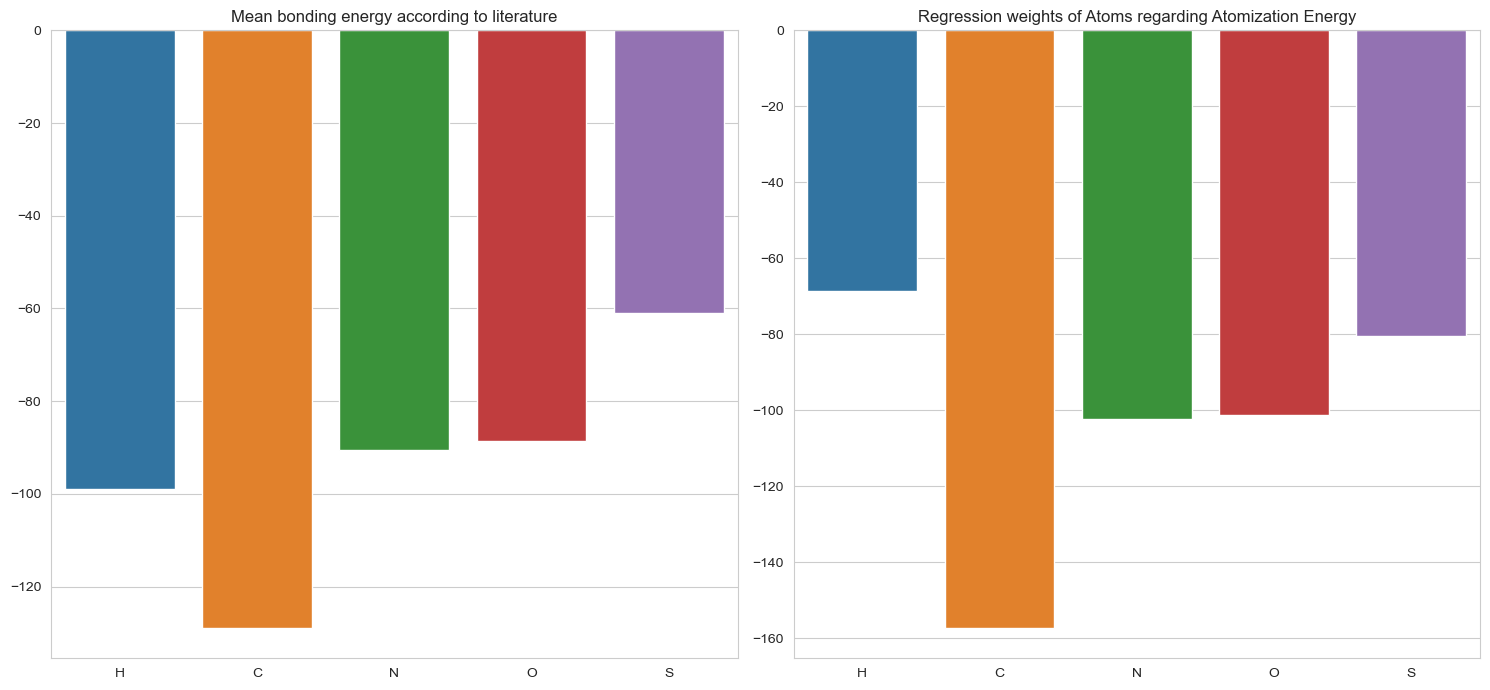

In [93]:
fig, axs = plt.subplots(1,2, figsize=(15,7))

g = sns.barplot(x=atoms, y=(-1) * mean_binding_energies, ax=axs[0])
g.set_title("Mean bonding energy according to literature")

f = sns.barplot(x=atoms, y=search.best_estimator_.coef_, ax=axs[1])
f.set_title("Regression weights of Atoms regarding Atomization Energy")
plt.tight_layout()
plt.show()


Comparing our results with the above-described literature, we can see that our results nearly perfectly match the findings. This is true for the ordering as well as the magnitudes of the atom influences. The only exception here is the hydrogen atom which’s impact is overestimated. Also, the Carbon impact is a little overestimated as well. However, as emphasized we are dealing with simplified approaches and differences may reasonably occur. One possible reason for this might be the pairwise discoverd correlations among H, C and the target variable. 

Overall, the results seem surprisingly satisfying!

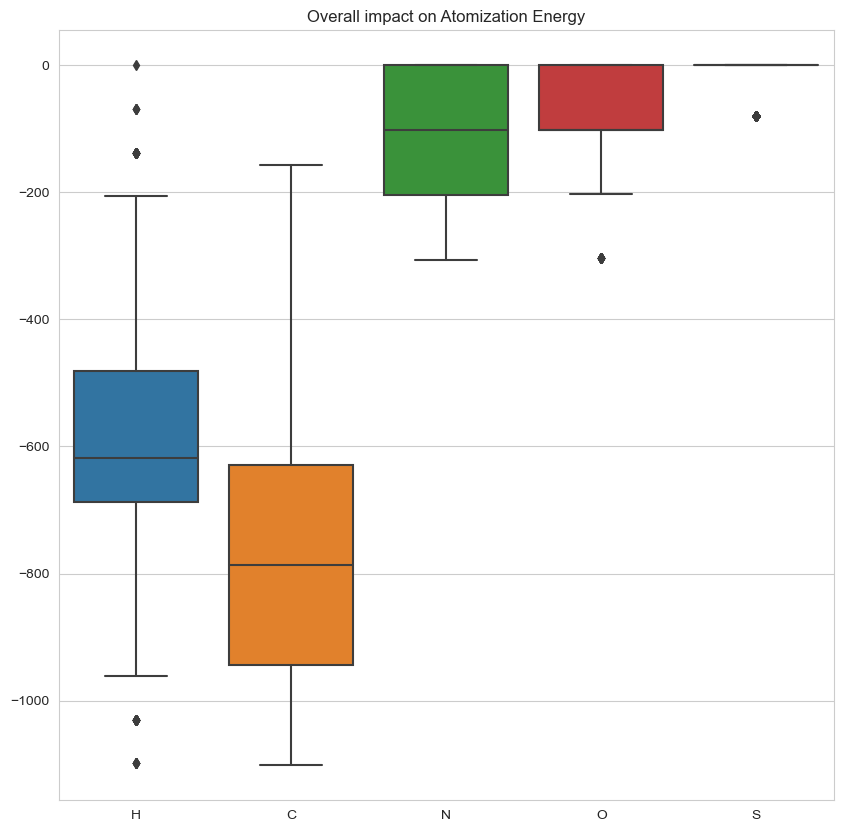

In [94]:
fig = plt.figure(figsize=(10,10))
g = sns.boxplot(x * search.best_estimator_.coef_)
g.set_title("Overall impact on Atomization Energy")
g.set_xticklabels(atoms)
plt.show()

# 3.2 Models with Pairs of Atoms

In [70]:
# create dictionary to translate atom combinations to number between 0 and 14
d = {c: i for i, c in enumerate(combinations_with_replacement([1, 2, 3, 4, 5], r=2))}

# add inverse tuples pointing to same number
inv = {}
for c in d:
    inv[c[1], c[0]] = d[c]

# merge dictionaries
d = d | inv
del inv

In [71]:
# generate arrays with the distances and the types of all pairs
N_COMB = 824783
pair_dist = np.zeros(N_COMB) # all distances
pair_type = np.zeros(N_COMB).astype(int) # all types
mol_split = np.zeros(7165 + 1).astype(int) # indices where to split the array to get the molecules
pair_idx = 0

for i in range(len(z)):
    sym = z[i]
    sym = sym[sym != 0]
    mol = qm7["R"][i][: len(sym)]

    dist = pdist(mol, metric="euclidean")
    comb = [*combinations(sym, r=2)]
    n_combs = len(comb)
    
    pair_dist[pair_idx : pair_idx + n_combs] = dist
    pair_type[pair_idx : pair_idx + n_combs] = [d[x] for x in comb]

    mol_split[i] = pair_idx
    pair_idx += n_combs

mol_split[-1] = N_COMB

In [72]:
def generate_representaions(THETA_1, THETA_M, STD, M, soft = True):

    intervals = np.linspace(THETA_1, THETA_M, M)
    interval_size = (THETA_M - THETA_1) / (M - 1)
    interval_centeres = intervals[:-2] + interval_size

    # generate phi_A(Ei) using specified hard or soft encoding
    phi_A = np.zeros((len(pair_dist), M))

    if soft:
        for j, mu in enumerate(interval_centeres):
            phi_A[:, j] = norm.pdf(pair_dist, loc=mu, scale=STD)
    else: 
        indices = np.floor((pair_dist - THETA_1) / interval_size).astype(int)
        phi_A[indices < M] = np.eye(M)[indices[indices < M]]

    # generate phi_B(Ei)
    phi_B = np.eye(15)[pair_type].astype(int)

    # generate phi(Ei)
    phi_AB = phi_A[:, :, None] * phi_B[:, None, :]
    phi_AB = phi_AB.reshape(N_COMB, -1)

    # aggregate for molecule representation
    reps = np.zeros((len(z), M * 15))
    for i in range(len(mol_split)):
        reps[i - 1, :] = np.sum(phi_AB[mol_split[i - 1] : mol_split[i]], axis=0)
        
    return reps


In [73]:
def plot_pp(model, M, THETA_1, THETA_M, **kwargs):

    # All pairwise potentials plots
    fig, axes = plt.subplots(5, 3, figsize=(12, 20))
    axes = axes.flatten()
    pair_names = [*combinations_with_replacement(atoms, r=2)]
    intervals = np.linspace(THETA_1, THETA_M, M)
    
    for i in range(15):
        g = sns.lineplot(x=intervals, y=model.coef_.reshape(M, 15)[:, i], ax=axes[i])
        g.set_xlabel("Distance")
        g.set_ylabel("Coefficient")
        name = str(pair_names[i]).replace("'", "")
        g.set_title(f"Pairwise potentials {name}")
    plt.tight_layout()

In [74]:
def fit_and_eval_model(Model, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M):
    model = Model(alpha=ALPHA, max_iter= 10000)
    model.fit(X_train, y_train)

    print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}")
    print(f"#coef = 0: {np.sum(model.coef_ == 0)}")
    print(f"#coef < 1e-10: {np.sum(model.coef_ < 1e-10)}")

    plot_pp(model, M, THETA_1, THETA_M)

## GRID SEARCH TUNING (soft encoding)

In [75]:
from sklearn.model_selection import ParameterGrid
from sklearn.utils import shuffle
import pickle


param_grid = {
    "M": [10, 40, 70, 100],
    "STD": np.linspace(0.01, 0.1, 10),
    "THETA_1": [1.3], #'[2],
    "THETA_M": [5.1] #[4, 8],
}

print(len(list(ParameterGrid(param_grid))))


alpha_values = np.logspace(np.log10(1e-4), np.log10(10000), num=100)

results = []

# TODO justify shuffle decision
# use same shuffle for every grid search but shuffle once because it seems to have an effect see below
shuffled_index = shuffle(range(len(qm7["T"][0])))


# Do search or load results from grid_search.p
DO_SEARCH = False

if DO_SEARCH:
    for p in ParameterGrid(param_grid):

        reps = generate_representaions(**p, soft=True)

        # TODO use all data for grid search? or report real test error additionally?
        X_train, X_test, y_train, y_test = split_and_center(
            reps[shuffled_index],
            qm7["T"][0][shuffled_index],
            test_size=0.2, 
            shuffle=False,
        )

        ridge = Ridge()
        grid = dict(alpha=alpha_values)
        search = GridSearchCV(
            ridge,
            grid,
            scoring=("neg_mean_absolute_error"),
            cv=5,
            n_jobs=-1,
            # refit="neg_mean_absolute_error",
            return_train_score=True,
        )
        search = search.fit(X_train, y_train)

        print(p, search.best_score_, search.best_params_)

        results += [{"params": p, "search": search}]
    pickle.dump(results, open("grid_search.p", "wb"))
else:
    results = pickle.load(open("grid_search.p", "rb"))


40


/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [76]:
res_df = pd.DataFrame([r["params"] for r in results])
res_df["model_idx"] = res_df.index
res_df['best_score'] = [r['search'].best_score_ for r in results]
res_df['best_alpha'] = [r["search"].best_params_["alpha"] for r in results]
res_df['n_coef_smaller_1e-4'] = [np.sum(r['search'].best_estimator_.coef_ < 1e-4) for r in results]
res_df

,M,STD,THETA_1,THETA_M,model_idx,best_score,best_alpha,n_coef_smaller_1e-4
0,10,0.1,2,4,0,-27.008538,0.572237,122
1,10,0.1,2,6,1,-52.756180,10.722672,112
2,10,0.1,2,8,2,-61.635199,0.017475,103
3,10,0.1,2,10,3,-65.119414,4.037017,106
4,10,0.5,2,4,4,-8.210599,0.000100,98
5,10,0.5,2,6,5,-10.163544,0.000305,99
6,10,0.5,2,8,6,-18.180236,0.030539,103
7,10,0.5,2,10,7,-16.231084,0.247708,124
8,10,1.0,2,4,8,-10.124156,0.000100,97
9,10,1.0,2,6,9,-9.597285,0.000100,96


In [77]:
def recreate_and_score(model, params, shuffled_index):
    # calculate mae on actual test set
    # recreate reps and train/test data
    reps = generate_representaions(**params, soft=True)

    X_train, X_test, y_train, y_test = split_and_center(
        reps[shuffled_index],
        qm7["T"][0][shuffled_index],
        test_size=0.2, 
        shuffle=False,
    )

    return mean_absolute_error(y_test, model.predict(X_test))

## The best model in terms of MAE (soft encoding)

In [78]:
# overall best model in terms of MAE
best_idx = np.argmax([r['search'].best_score_ for r in results])
best_model = results[best_idx]['search']
print("Best model index:", best_idx)
print("Best alpha:", best_model.best_params_['alpha'])
print("Validation MAE:", -best_model.best_score_)
print("Params:", results[best_idx]['params'])

Best model index: 33
Best alpha: 0.013219411484660288
Validation MAE: 5.739446460146804
Params: {'M': 100, 'STD': 0.1, 'THETA_1': 2, 'THETA_M': 6}


In [79]:
test_score = recreate_and_score(best_model.best_estimator_, results[best_idx]['params'], shuffled_index)
print("Test MAE:", test_score)

[2.66487319e-23 2.93742447e+01 1.57905114e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Test MAE: 4.852941828467685


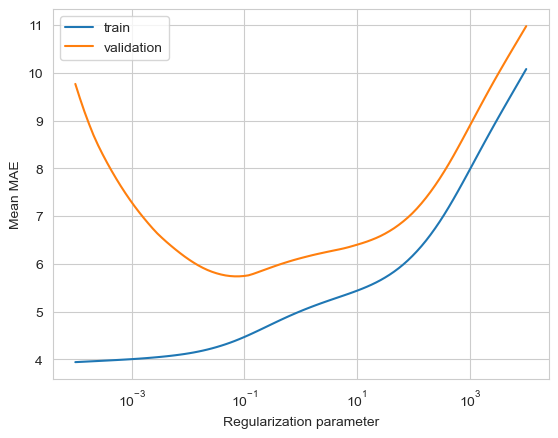

In [80]:
ax = sns.lineplot(x=alpha_values, y = -best_model.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -best_model.cv_results_['mean_test_score'], label='validation')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

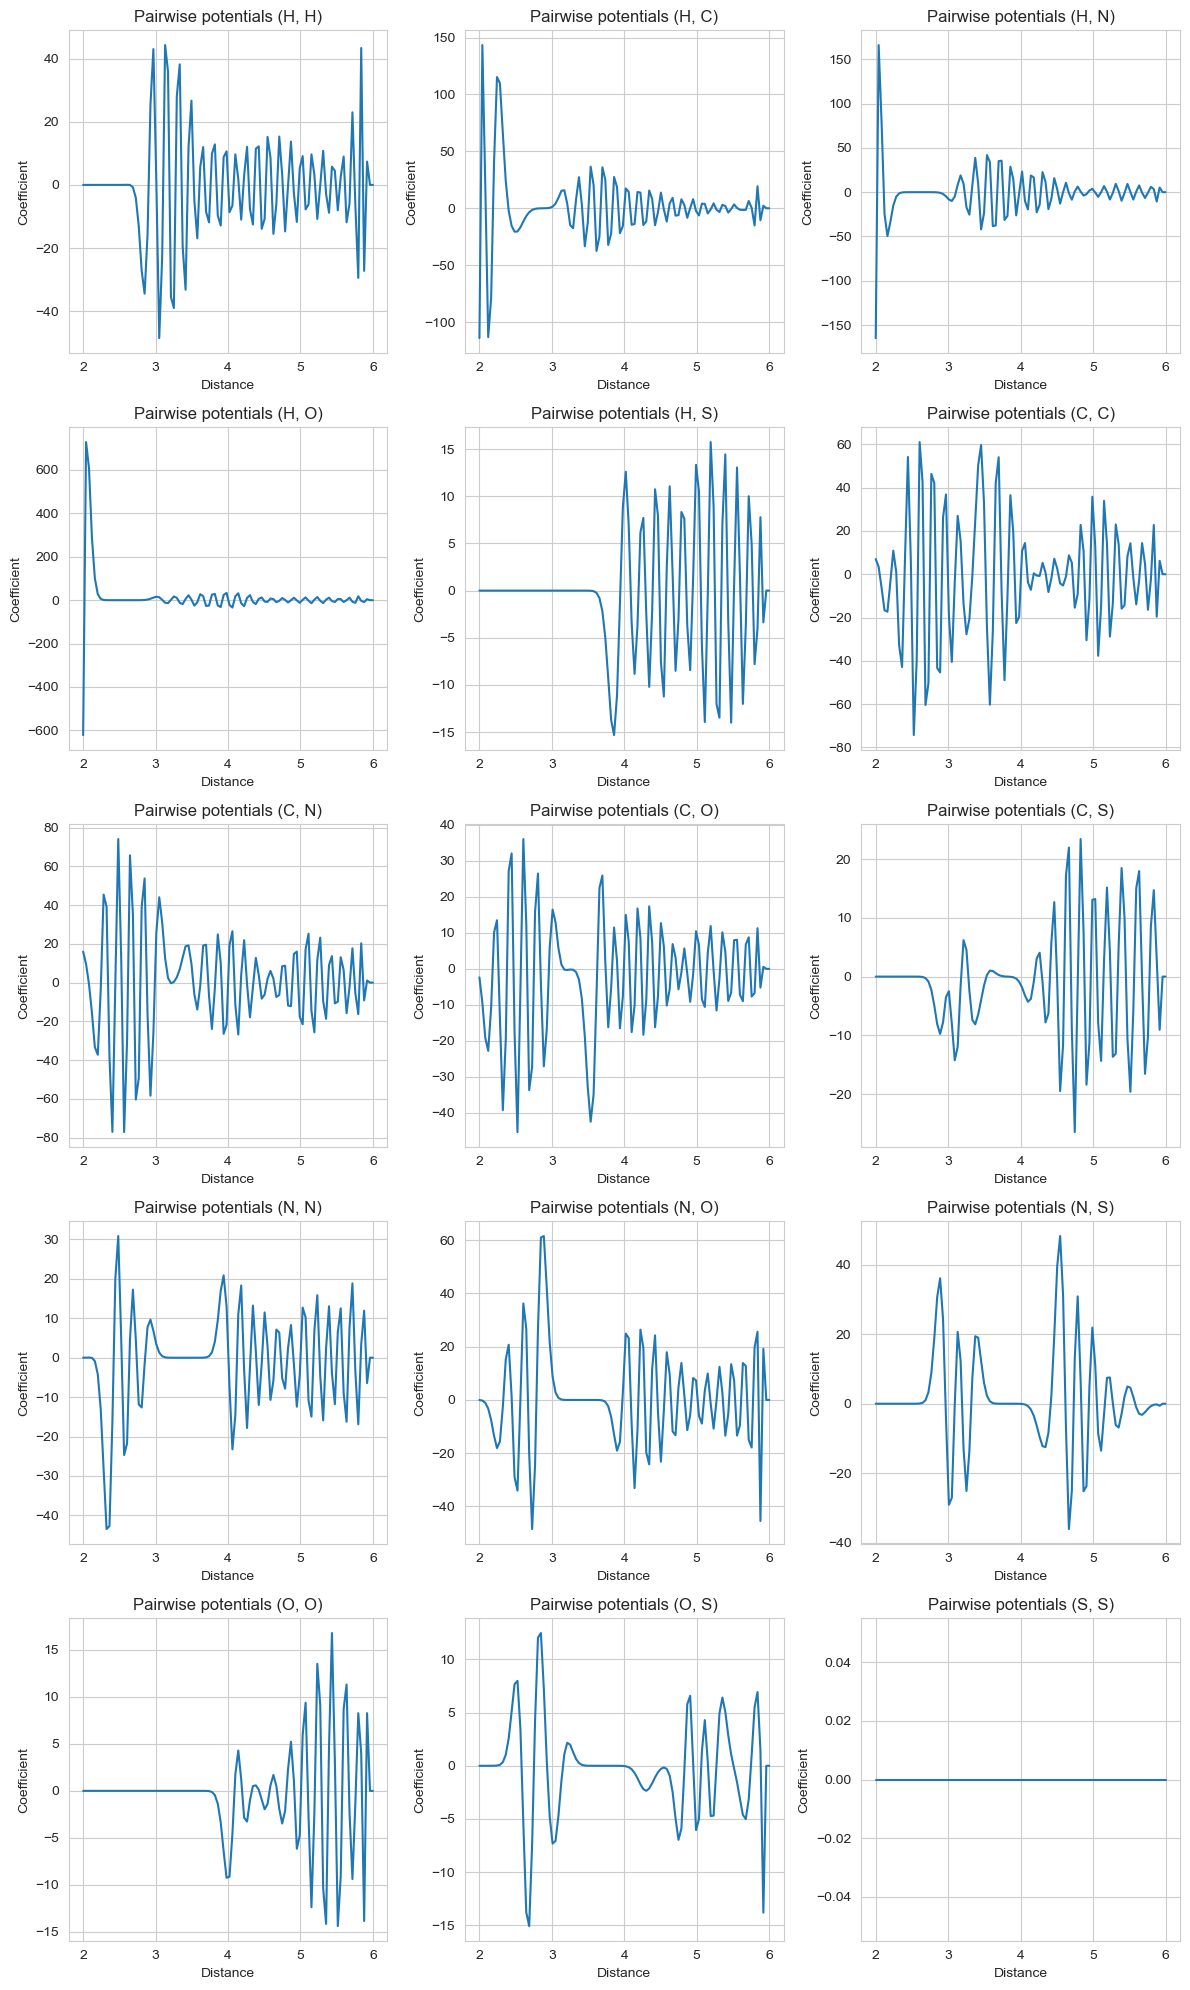

In [81]:
plot_pp(best_model.best_estimator_, **results[best_idx]['params'])

## For comparison: Multiple Linear Regression (same parameters)

[2.96853388e-63 2.08192783e-10 9.23498229e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
MAE: 6759414619.867
#coef = 0: 87
#coef < 1e-10: 817


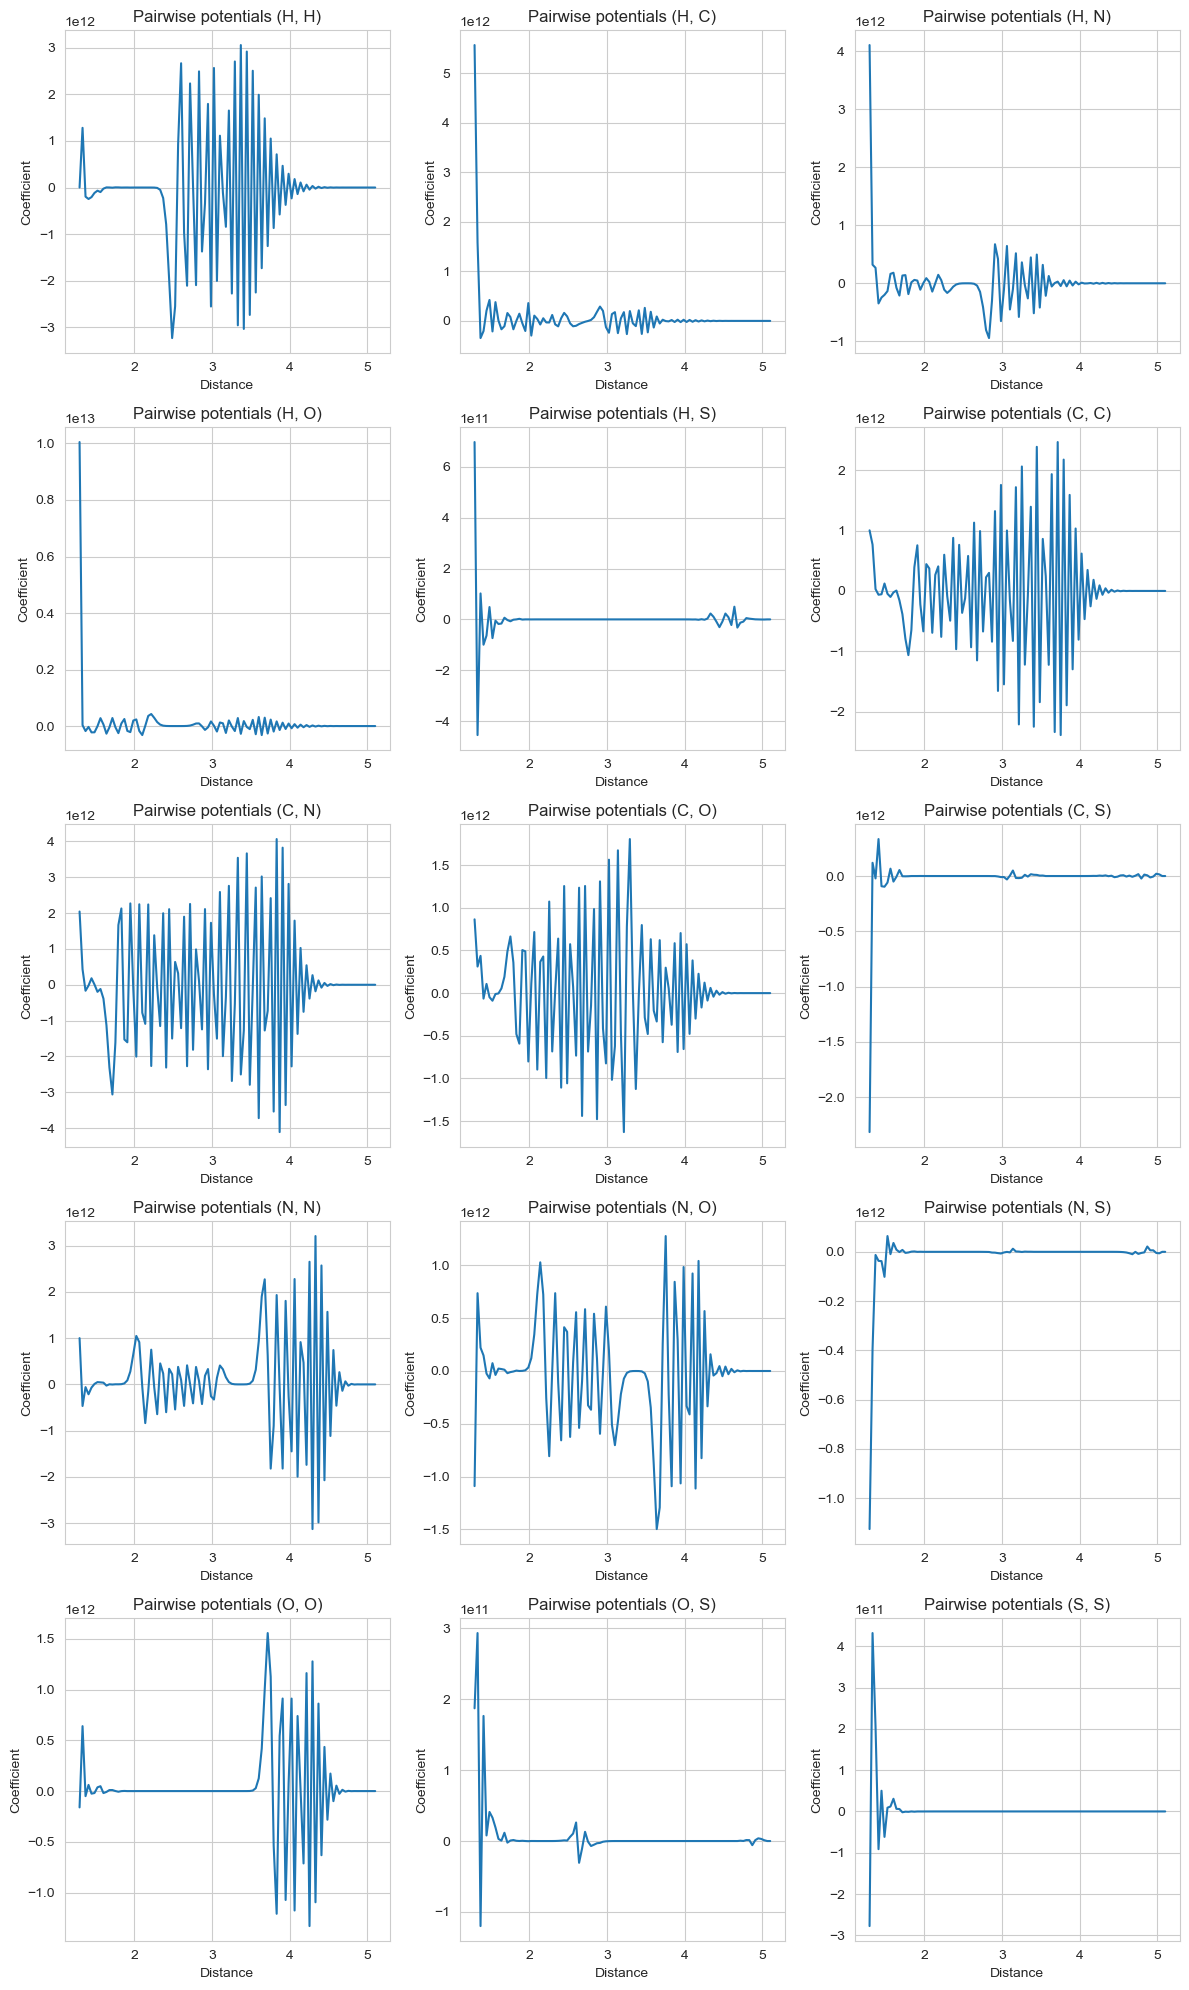

In [83]:
reps = generate_representaions(1.3, 5.1, 0.1, 100, soft=True)
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3, shuffle=False)
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f"MAE: {mean_absolute_error(y_test, lr.predict(X_test)):.3f}")
print(f"#coef = 0: {np.sum(lr.coef_ == 0)}")
print(f"#coef < 1e-10: {np.sum(lr.coef_ < 1e-10)}")

plot_pp(lr, 100, 1.3, 5.1)

## The best model in terms of explainability (soft encoding)

#### Effect of shuffle: TODO

In [85]:
# TODO I noticed that shuffling the data seems to have an effect
# the molecules seem to have some kind of ordering, maybe some more complex at the last 30%?
# example only change if shuffle or not:

THETA_1 = 1.3
THETA_M = 5.1
STD = .1
M = 100
ALPHA = 1000

reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=True)

# DONT SHUFFLE
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3, shuffle=False)
model = Ridge(alpha=ALPHA, max_iter= 10000).fit(X_train, y_train)
print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}")
    
# SHUFFLE
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3, shuffle=True)
model = Ridge(alpha=ALPHA, max_iter= 10000).fit(X_train, y_train)
print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}")

[2.96853388e-63 2.08192783e-10 9.23498229e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
MAE: 16.678
[4.70216573e-64 1.96590101e-10 1.15344697e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
MAE: 9.673


## Manual parameter search

[0.13968671 6.06509849 0.59057876 ... 0.         0.         0.        ]
MAE: 7.840
#coef = 0: 128
#coef < 1e-10: 854


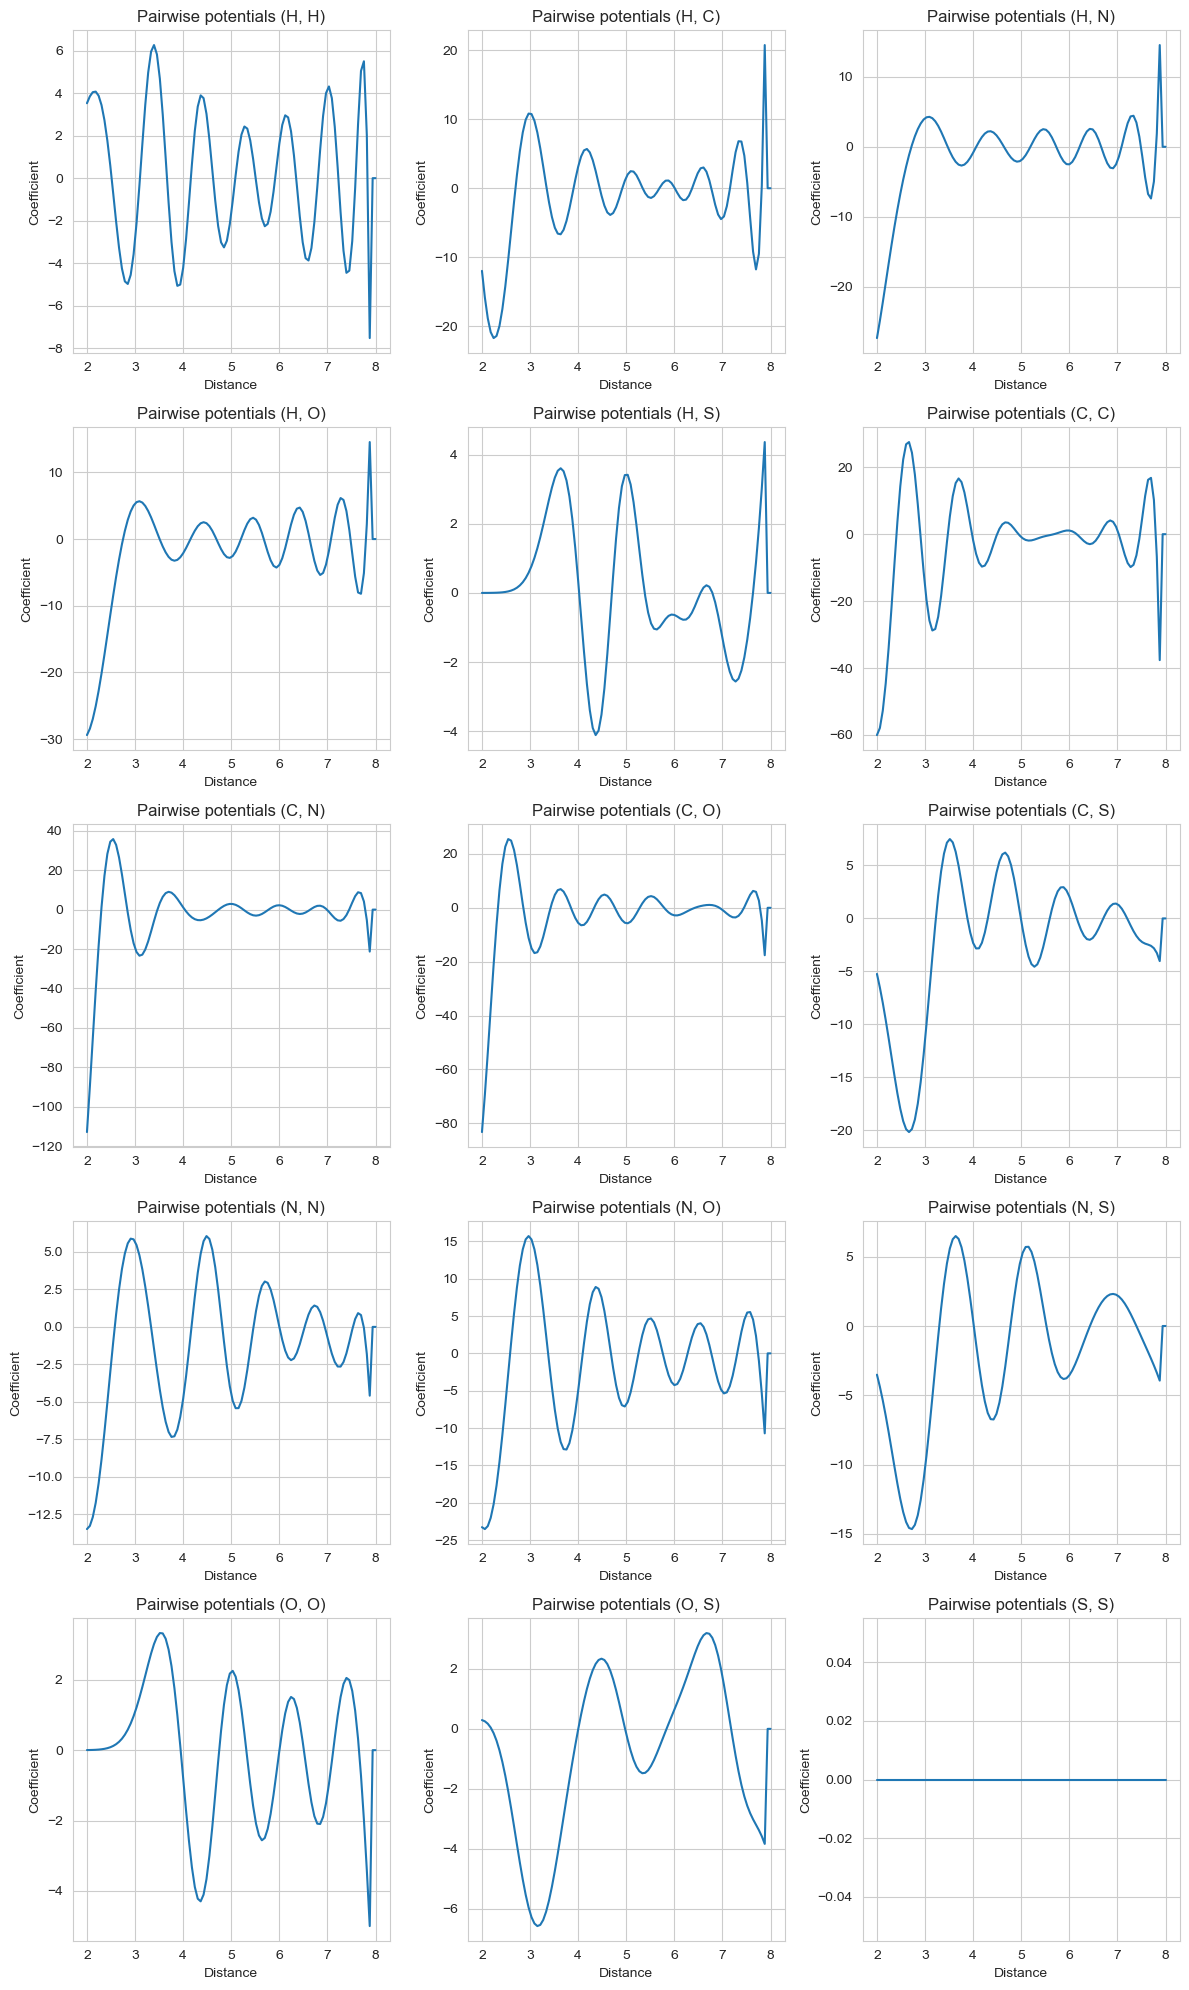

In [86]:
# Approach: look at numbers of coefficients higher than 1e-4
#res_df.sort_values(by='n_coef_smaller_1e-4', ascending=False).head(20)

THETA_1 = 2
THETA_M = 8
STD = .5
M = 100

ALPHA = 1

reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=True)
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3)
fit_and_eval_model(Ridge, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)


## For comparison: **HARD** encoding. Ridge regression with the same parameters

[0.         1.90907278 0.         ... 0.00219342 0.         0.        ]
MAE: 11.921
#coef = 0: 570
#coef < 1e-10: 1303


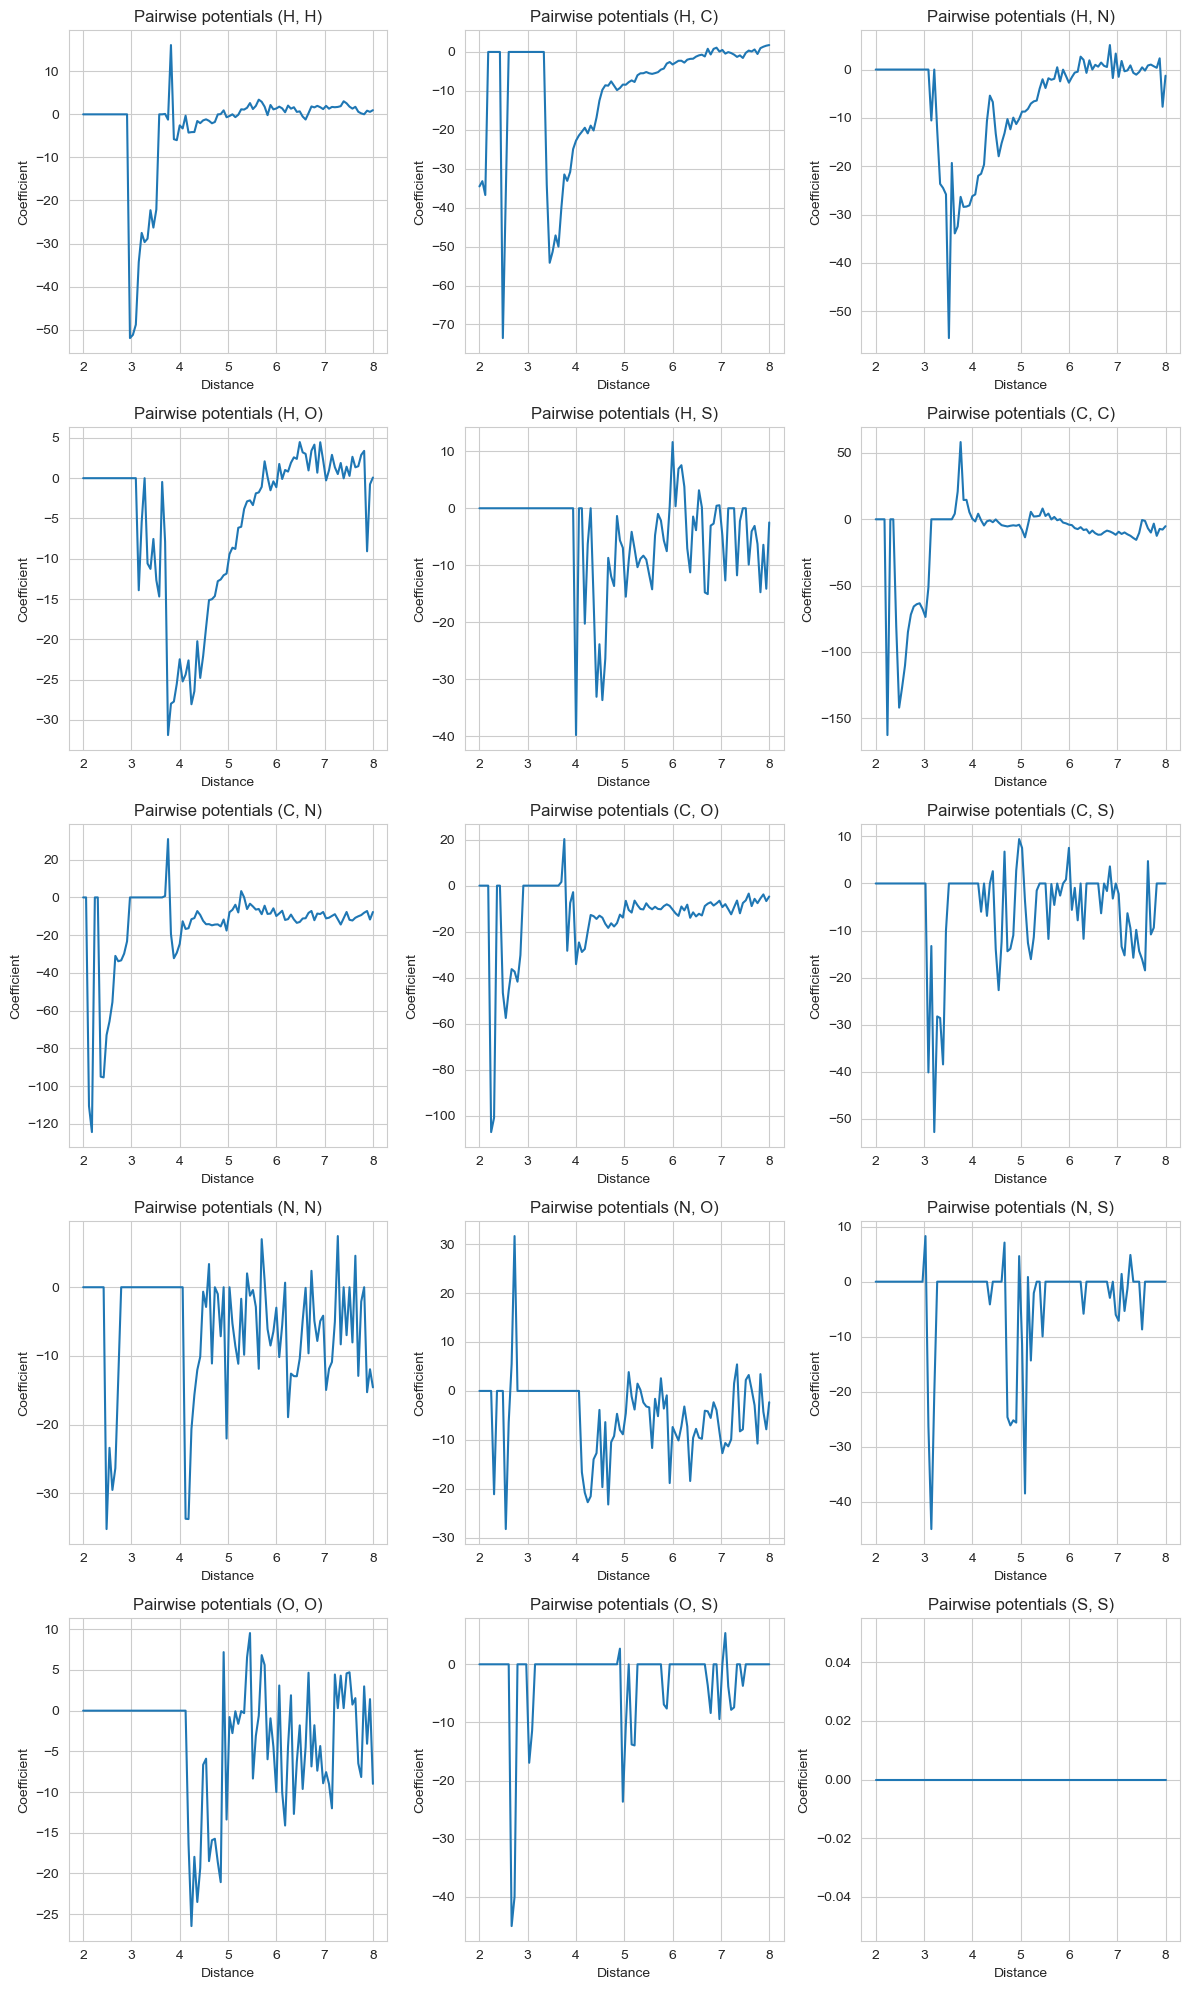

In [87]:
reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=False)
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3)

fit_and_eval_model(Ridge, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)